<a href="https://colab.research.google.com/github/Jmmostafa/DerivativePricing/blob/main/DP003BS_BP_TP_MC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Derivative Pricing II- Options**

|  |  |
|:---|:---|
|**Developed By** |  Md Mostafa Kamal |
|**Date** | October 1, 2025  |
|**Covered** | Options Pricing -- Monte Carlo Simulation, Application |
|**Python** | OOP, Numpy, Pandas, Scienceplots, Matplotlib|
|**Sequence** | DP003 |


---

# **Introduction**


Options pricing is about computing the (discounted) expected payoff of a derivative under an appropriate probability measure. For European options on non-dividend-paying stocks it's common to model the stock price by geometric Brownian motion (GBM) and price the option using the Black–Scholes (BS) closed-form formula under the *risk-neutral* measure. Monte Carlo (MC) simulation offers a flexible alternative: simulate terminal stock prices, compute payoffs, discount, and average.

This notebook demonstrates Monte Carlo pricing for a European call, compares it to the Black–Scholes price, and explores how the Monte Carlo estimate behaves when you simulate using a *real-world* drift for the underlying (i.e., a drift ≠ risk-free rate). We also include variance reduction (antithetic variates and a control variate built from the terminal stock) and convergence plots.



# **Mathematical Framework and Formulae**


Assume the stock price follows a *Geometric Brownian Motion* under the real-world measure P:

$$dS_t = \mu S_t dt + \sigma S_t dW_t^P, \qquad S_0 > 0$$

Under the **risk-neutral** measure Q the drift becomes the risk-free rate (r):

$$dS_t = r S_t dt + \sigma S_t dW_t^Q.$$

## **BS Model**

**Closed-form (Black--Scholes)** price for a European call with strike $K$ and maturity $T$ (no dividends):

Let
$$d_{1,2} = \frac{\ln(S_0/K) + (r \pm \tfrac{1}{2}\sigma^2)T}{\sigma\sqrt{T}},$$
then
$$C_{BS} = S_0\,\Phi(d_1) - K e^{-rT} \Phi(d_2),$$
where $\Phi$ is the standard normal CDF.

## **Monte Carlo Method**

Monte Carlo (risk-neutral) estimator for the call price:

Simulate $S_T^{(i)}$ from the risk-neutral dynamics:
$$S_T = S_0 \exp\left((r - \tfrac{1}{2}\sigma^2)T + \sigma \sqrt{T} Z\right), \quad Z\sim N(0,1).$$

Compute payoff $X^{(i)} = e^{-rT}\max(S_T^{(i)} - K,0)$. The MC estimator is
$$\hat{C}_{MC} = \frac{1}{N}\sum_{i=1}^N X^{(i)}$$
with sample standard error
$$\text{SE} = \frac{\widehat{\mathrm{std}}(X)}{\sqrt{N}}.$$

If we simulate under the real-world drift $\mu$ instead of $r$, the discounted expectation $e^{-rT}\mathbb{E}^P[\max(S_T-K,0)]$ will generally *not* equal the Black–Scholes price — this demonstrates the importance of using the risk-neutral measure for pricing.

## **Variance Reduction Methods**

1. **Antithetic variates:** For each normal $Z$ simulate also $-Z$ and average the two payoffs.

2. **Control variate (terminal stock):** Use the discounted terminal stock price $Y = e^{-rT} S_T$ as a control variate. We know its expectation under the risk-neutral measure:
$$\mathbb{E}^Q[Y] = e^{-rT} \mathbb{E}^Q[S_T] = e^{-rT} S_0 e^{rT} = S_0.$$
Given MC payoff $X$ and control $Y$, use
$$\hat{X}_{cv} = \bar{X} - \beta (\bar{Y} - \mathbb{E}[Y]),$$
with $\beta$ chosen as $\beta^* = \mathrm{Cov}(X,Y)/\mathrm{Var}(Y)$ (estimated from the sample).



In [ ]:
!pip install yfinance numpy scipy matplotlib scienceplots --quiet
!apt-get update -qq
!apt-get install -y texlive-latex-extra texlive-fonts-recommended dvipng cm-super --quiet


# For latex text in the graphs
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "text.latex.preamble": r"\usepackage{amsmath}"
})

OPTION PRICING ANALYSIS
S0=100, K=100, r=0.01, sigma=0.2, T=1
Option type: C
Black-Scholes price: 8.433319
Plain MC (risk-netural)   price: 8.442617  SE: 0.030108  Error: 0.009298
Antithetic Variates       price: 8.436589  SE: 0.030135  Error: 0.003271
Control Variate           price: 8.447339  SE: 0.013298  Error: 0.014021
  -> Control variate beta: 0.597706
Real-world (mu=0.08)      price: 12.999062  SE: 0.037393  Error: 4.565743


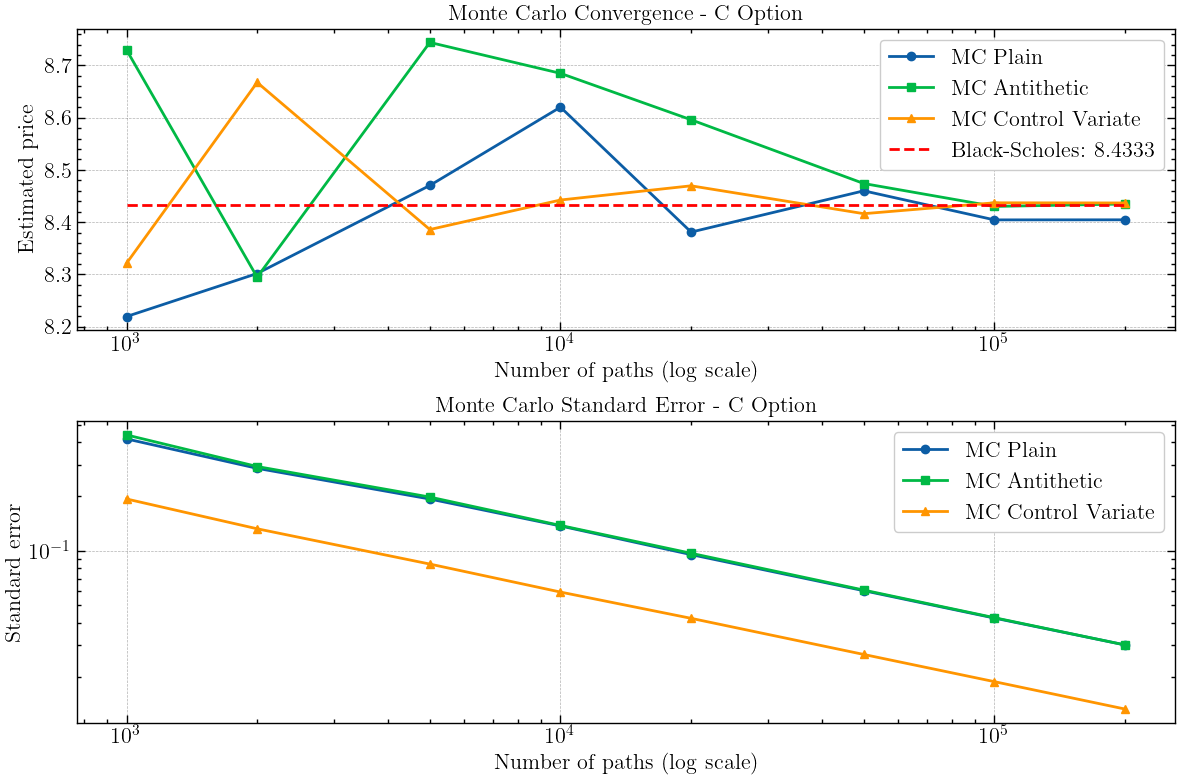

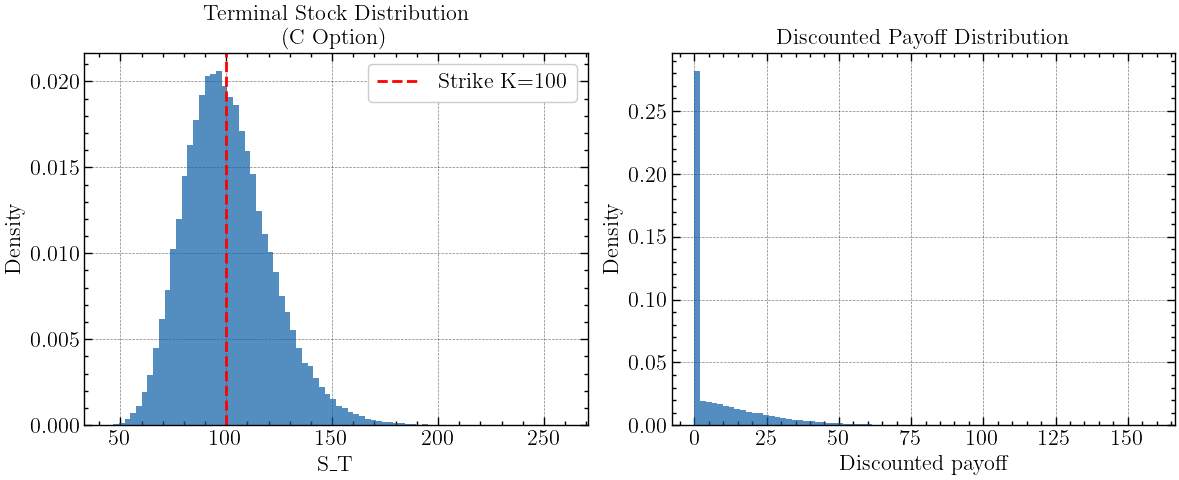


PUT OPTION ANALYSIS
OPTION PRICING ANALYSIS
S0=100, K=100, r=0.01, sigma=0.2, T=1
Option type: P
Black-Scholes price: 7.438302
Plain MC (risk-netural)   price: 7.439380  SE: 0.022485  Error: 0.001078
Antithetic Variates       price: 7.436712  SE: 0.022456  Error: 0.001591
Control Variate           price: 7.441111  SE: 0.013296  Error: 0.002809
  -> Control variate beta: -0.400092
Real-world (mu=0.08)      price: 4.736759  SE: 0.018331  Error: 2.701543


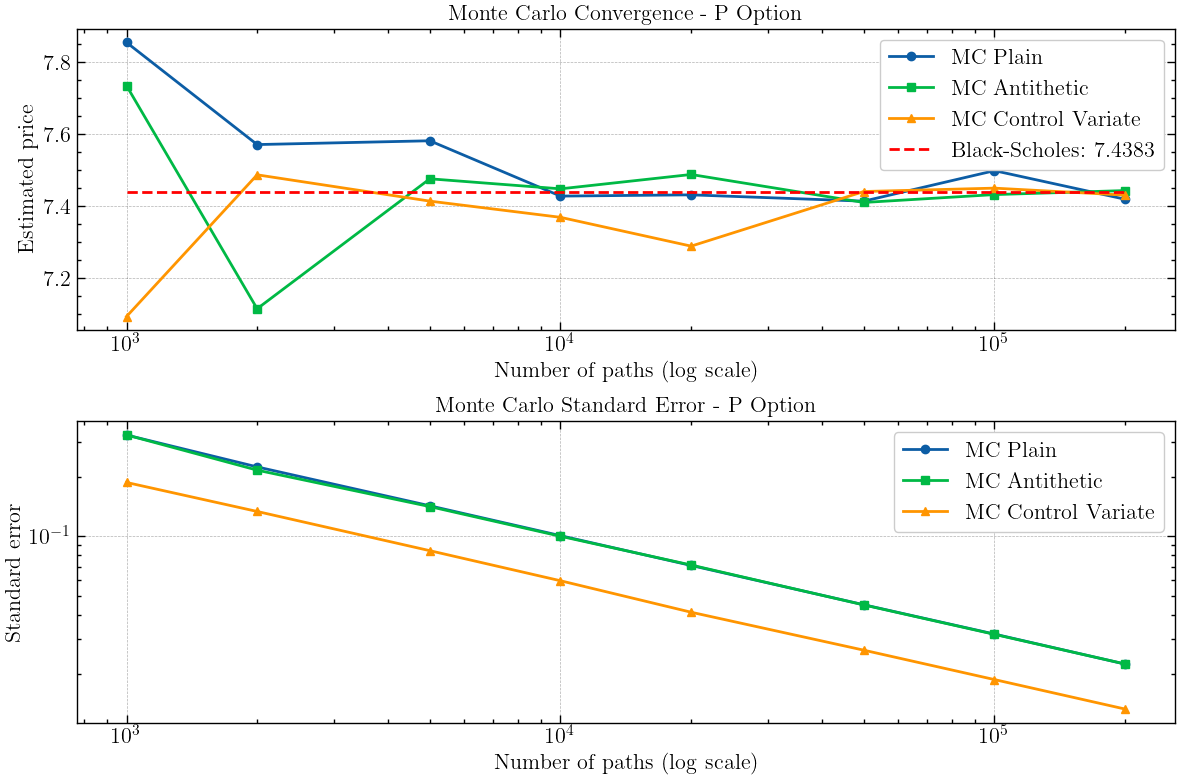

In [102]:
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
from math import log, sqrt, exp

np.random.seed(42)

# Creating OOP command pricing under BS and Monte Carlo
class BS_Model:
  def __init__(self, S0, K, r, sigma, T, option_type='C'):
    self.S0 = S0
    self.K = K
    self.r = r
    self.sigma = sigma
    self.T = T
    self.option_type = option_type

  def BS_Price(self):
    if self.T <= 0:
      if self.option_type == 'C':
        return max(self.S0 - self.K, 0.0)
      else:
        return max(self.K - self.S0, 0.0)

    if self.sigma <= 0:
      ST = self.S0 * np.exp(self.r * self.T)
      if self.option_type == 'C':
        return np.exp(-self.r * self.T) * max(ST - self.K, 0.0)
      else:
        return np.exp(-self.r * self.T) * max(self.K - ST, 0.0)


    d1 = (np.log(self.S0 / self.K) + ((self.r + 0.5 * self.sigma ** 2) * self.T)) / (self.sigma * np.sqrt(self.T))
    d2 = d1 - self.sigma * np.sqrt(self.T)
    if self.option_type == 'C':
      return self.S0 * st.norm.cdf(d1) - self.K * np.exp(-self.r * self.T) * st.norm.cdf(d2)
    else:
      return self.K * np.exp(-self.r * self.T) * st.norm.cdf(-d2) - self.S0 * st.norm.cdf(-d1)

class MonteCarlo:
  def __init__(self, S0, K, r, sigma, T, option_type='C'):
    self.S0 = S0
    self.K = K
    self.r = r
    self.sigma = sigma
    self.T = T
    self.option_type = option_type

  def MC_Simulated_Paths(self, n_paths, antithetic = False, mu = None):
    if n_paths < 1:
      raise ValueError("n_paths must be >= 1")
    if self.T < 0:
      raise ValueError("T must be non-negative")
    if self.sigma < 0:
      raise ValueError("sigma must be non-negative")

    drift = (self.r - 0.5 * self.sigma ** 2) if mu is None else (mu - 0.5 * self.sigma ** 2)
    sqrtT = np.sqrt(self.T) if self.T > 0 else 0

    if antithetic:
      half = n_paths // 2
      Z_half = np.random.normal(size=half)
      if n_paths % 2 == 0:
        Z = np.concatenate([Z_half, -Z_half])
      else:
        Z = np.concatenate([Z_half, -Z_half, np.random.normal(size=1)])
    else:
      Z = np.random.normal(size=n_paths)

    # Calculating the simulated terminal prices
    if self.T > 0:
      ST = self.S0 * np.exp(drift * self.T + self.sigma * sqrtT * Z)
    else:
      ST = np.full_like(Z, self.S0, dtype=float)

    return ST, Z


  def MC_Payoff(self, ST):
    if self.option_type == 'C':
      return np.maximum(ST - self.K, 0.0)
    else:
      return np.maximum(self.K - ST, 0.0)


  def MC_Price(self, n_paths = 100000, antithetic = False, control_variate = False, mu = None):
    ST, Z = self.MC_Simulated_Paths(n_paths, antithetic, mu)
    payoffs = self.MC_Payoff(ST)
    discounted = np.exp(-self.r * self.T) * payoffs

    # Basic Monte Carlo
    mc_mean = discounted.mean()
    mc_se = discounted.std(ddof=1) / np.sqrt(len(discounted))
    extra = None

    # Reducing Variance with Control Variate Method
    if control_variate:
      Y = np.exp(-self.r * self.T) * ST
      X = discounted
      cov_XY = np.cov(X, Y, ddof=1)[0, 1]
      var_Y = np.var(Y, ddof=1)
      beta = cov_XY / var_Y if var_Y > 0 else 0.0

      EY = self.S0 # Known expectation under the risk neutral pricing
      X_bar = X.mean()
      Y_bar = Y.mean()
      X_cv = X_bar - beta * (Y_bar - EY)

      # Adjusted values for standard error
      X_adjusted = X - beta * (Y - EY)
      se_cv = X_adjusted.std(ddof=1) / np.sqrt(len(X_adjusted))

      extra = {
          'beta': float(beta),
          'EY_used': float(EY),
          'Y_bar': float(Y_bar),
          'X_bar': float(X_bar),
          'note': 'EY_used = S0 is exact under the risk neutral dynamics.'
      }
      return float(X_cv), float(se_cv), extra

    return float(mc_mean), float(mc_se), extra

  # Now let's study the convergence
  def MC_Convergence_Study(self, ns, antithetic = False, control_variate = False, mu = None):
    estimates = []
    standard_errors = []
    for n in ns:
      price, se, _ = self.MC_Price(n_paths=n, antithetic=antithetic, control_variate=control_variate, mu=mu)
      estimates.append(price)
      standard_errors.append(se)
    return np.array(estimates), np.array(standard_errors)

  def MC_Terminal_Distribution(self, n_paths = 200000, mu = None):
    ST, _ = self.MC_Simulated_Paths(n_paths, antithetic=False, mu=mu)
    payoffs = self.MC_Payoff(ST)
    discounted_payoffs = np.exp(-self.r * self.T) * payoffs

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(ST, bins=80, density=True, alpha=0.7)
    plt.axvline(x=self.K, color='r', linestyle='--', label=f'Strike K={self.K}')
    plt.title(f'Terminal Stock Distribution\n({self.option_type.capitalize()} Option)')
    plt.xlabel('S_T')
    plt.ylabel('Density')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(discounted_payoffs, bins=80, density=True, alpha=0.7)
    plt.title('Discounted Payoff Distribution')
    plt.xlabel('Discounted payoff')
    plt.ylabel('Density')

    plt.tight_layout()
    plt.show()

class OptionAnalysis:
  def __init__(self, S0, K, r, sigma, T, option_type='C'):
    self.S0 = S0
    self.K = K
    self.r = r
    self.sigma = sigma
    self.T = T
    self.option_type = option_type
    # Stacking the pricing objects
    self.bs_pricer = BS_Model(S0, K, r, sigma, T, option_type)
    self.mc_pricer = MonteCarlo(S0, K, r, sigma, T, option_type)

  def Run_Comprehensive_Analysis(self, n_paths = 200000, mu_real_world = 0.08):
    print("=" * 60)
    print(f"OPTION PRICING ANALYSIS")
    print(f"S0={self.S0}, K={self.K}, r={self.r}, sigma={self.sigma}, T={self.T}")
    print(f"Option type: {self.option_type}")
    print("=" * 60)

    # Black-Scholes price
    bs_price = self.bs_pricer.BS_Price()
    print(f"Black-Scholes price: {bs_price:.6f}")

    # All Methods of Monte Carlo with Variance Reductions
    methods = [
        ("Plain MC (risk-netural)", {'antithetic': False, 'control_variate': False}),
        ("Antithetic Variates", {'antithetic': True, 'control_variate': False}),
        ("Control Variate", {'antithetic': False, 'control_variate': True}),
        (f"Real-world (mu={mu_real_world})", {'antithetic': False, 'control_variate': False, 'mu': mu_real_world})
    ]

    for name, params in methods:
      price, se, extra = self.mc_pricer.MC_Price(n_paths=n_paths, **params)
      error = abs(price - bs_price)
      print(f"{name:25} price: {price:.6f}  SE: {se:.6f}  Error: {error:.6f}")
      if extra and 'beta' in extra:
        print(f"  -> Control variate beta: {extra['beta']:.6f}")

    return bs_price

  def Plot_Convergence_Comparison(self, ns = None):
    if ns is None:
      ns = [1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]
    bs_price = self.bs_pricer.BS_Price()

    # Getting the convergence data for different methods
    ests_plain, ses_plain = self.mc_pricer.MC_Convergence_Study(ns, antithetic=False, control_variate=False)
    ests_ant, ses_ant = self.mc_pricer.MC_Convergence_Study(ns, antithetic=True, control_variate=False)
    ests_cv, ses_cv = self.mc_pricer.MC_Convergence_Study(ns, antithetic=False, control_variate=True)

    plt.figure(figsize=(12, 8))

    # Price Convergence
    plt.subplot(2, 1, 1)
    plt.plot(ns, ests_plain, marker='o', label='MC Plain', linewidth=2)
    plt.plot(ns, ests_ant, marker='s', label='MC Antithetic', linewidth=2)
    plt.plot(ns, ests_cv, marker='^', label='MC Control Variate', linewidth=2)
    plt.hlines(bs_price, ns[0], ns[-1], linestyles='--', color='red', label=f'Black-Scholes: {bs_price:.4f}', linewidth=2)
    plt.xscale('log')
    plt.xlabel('Number of paths (log scale)')
    plt.ylabel('Estimated price')
    plt.title(f'Monte Carlo Convergence - {self.option_type.capitalize()} Option')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Standard error convergence
    plt.subplot(2, 1, 2)
    plt.plot(ns, ses_plain, marker='o', label='MC Plain', linewidth=2)
    plt.plot(ns, ses_ant, marker='s', label='MC Antithetic', linewidth=2)
    plt.plot(ns, ses_cv, marker='^', label='MC Control Variate', linewidth=2)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Number of paths (log scale)')
    plt.ylabel('Standard error')
    plt.title(f'Monte Carlo Standard Error - {self.option_type.capitalize()} Option')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# Testing
if __name__ == "__main__":
  S0 = 100
  K = 100
  r = 0.01
  sigma = 0.2
  T = 1
  mu_real_world = 0.08
  option_type = 'C'

  analysis = OptionAnalysis(S0, K, r, sigma, T, option_type)
  bs_price = analysis.Run_Comprehensive_Analysis()
  analysis.Plot_Convergence_Comparison()
  analysis.mc_pricer.MC_Terminal_Distribution()

# Example with put option
  print("\n" + "="*60)
  print("PUT OPTION ANALYSIS")
  print("="*60)

  put_analysis = OptionAnalysis(S0, K, r, sigma, T, option_type='P')
  put_bs_price = put_analysis.Run_Comprehensive_Analysis()
  put_analysis.Plot_Convergence_Comparison()



# **Application: AAPL**

In [103]:
from datetime import datetime
import yfinance as yf
import pandas as pd


# Use your existing time_to_expiry function
def time_to_expiry(expiry):
    expiry_date = datetime.strptime(expiry, "%Y-%m-%d")
    today = datetime.today()
    T = (expiry_date - today).days / 365   # in years
    return max(T, 0)

# Calculate time to expiry
T = time_to_expiry(expiry)
print(f"Time to expiry: {T:.4f} years")

# Set risk-free rate (you can adjust this)
r = 0.0439  # 4.39% risk-free rate

# Analyze CALL options
print("CALL OPTIONS ANALYSIS:")
print("=" * 60)
for _, option in calls.iterrows():
    K = option['strike']
    market_price = option['lastPrice']
    iv = option['impliedVolatility']

    # Skip if missing data
    if pd.isna(iv) or pd.isna(market_price):
        continue

    # Use your BS_Model class
    bs_model = BS_Model(S, K, r, iv, T, 'C')
    bs_price = bs_model.BS_Price()

    # Use your MonteCarlo class
    mc_model = MonteCarlo(S, K, r, iv, T, 'C')
    mc_price, mc_se, _ = mc_model.MC_Price(n_paths=50000, control_variate=True)

    # Calculate differences
    bs_diff = bs_price - market_price
    mc_diff = mc_price - market_price

    moneyness = "ITM" if K < S else "OTM" if K > S else "ATM"

    print(f"Strike: ${K:6.1f} | {moneyness:3} | "
          f"Market: ${market_price:5.2f} | IV: {iv:5.3f} | "
          f"BS: ${bs_price:5.2f} | MC: ${mc_price:5.2f} | "
          f"BS Diff: ${bs_diff:5.2f} | MC Diff: ${mc_diff:5.2f}")

# Analyze PUT options
print("\nPUT OPTIONS ANALYSIS:")
print("=" * 60)
for _, option in puts.iterrows():
    K = option['strike']
    market_price = option['lastPrice']
    iv = option['impliedVolatility']

    # Skip if missing data
    if pd.isna(iv) or pd.isna(market_price):
        continue

    # Use your BS_Model class
    bs_model = BS_Model(S, K, r, iv, T, 'P')
    bs_price = bs_model.BS_Price()

    # Use your MonteCarlo class
    mc_model = MonteCarlo(S, K, r, iv, T, 'P')
    mc_price, mc_se, _ = mc_model.MC_Price(n_paths=50000, control_variate=True)

    # Calculate differences
    bs_diff = bs_price - market_price
    mc_diff = mc_price - market_price

    moneyness = "ITM" if K > S else "OTM" if K < S else "ATM"

    print(f"Strike: ${K:6.1f} | {moneyness:3} | "
          f"Market: ${market_price:5.2f} | IV: {iv:5.3f} | "
          f"BS: ${bs_price:5.2f} | MC: ${mc_price:5.2f} | "
          f"BS Diff: ${bs_diff:5.2f} | MC Diff: ${mc_diff:5.2f}")

# Quick summary statistics
print("\n" + "=" * 60)
print("SUMMARY:")
print(f"Underlying: {ticker} @ ${S:.2f}")
print(f"Expiry: {expiry} (T = {T:.3f} years)")
print(f"Risk-free rate: {r:.1%}")
print("=" * 60)

Time to expiry: 0.6055 years
CALL OPTIONS ANALYSIS:
Strike: $   5.0 | ITM | Market: $248.90 | IV: 3.183 | BS: $254.31 | MC: $254.32 | BS Diff: $ 5.41 | MC Diff: $ 5.42
Strike: $  30.0 | ITM | Market: $179.90 | IV: 0.000 | BS: $228.81 | MC: $228.81 | BS Diff: $48.91 | MC Diff: $48.91
Strike: $  60.0 | ITM | Market: $146.61 | IV: 0.000 | BS: $199.59 | MC: $199.59 | BS Diff: $52.98 | MC Diff: $52.98
Strike: $  90.0 | ITM | Market: $167.85 | IV: 0.827 | BS: $172.17 | MC: $172.17 | BS Diff: $ 4.32 | MC Diff: $ 4.32
Strike: $  95.0 | ITM | Market: $147.04 | IV: 0.800 | BS: $167.43 | MC: $167.41 | BS Diff: $20.39 | MC Diff: $20.37
Strike: $ 100.0 | ITM | Market: $138.90 | IV: 0.771 | BS: $162.67 | MC: $162.69 | BS Diff: $23.77 | MC Diff: $23.79
Strike: $ 120.0 | ITM | Market: $140.60 | IV: 0.678 | BS: $143.78 | MC: $143.74 | BS Diff: $ 3.18 | MC Diff: $ 3.14
Strike: $ 125.0 | ITM | Market: $92.90 | IV: 0.000 | BS: $136.30 | MC: $136.30 | BS Diff: $43.40 | MC Diff: $43.40
Strike: $ 130.0 | ITM

In [104]:
def create_pricing_dataframes(calls, puts, S, T, r, n_paths=50000):
    """Create comprehensive dataframes with all pricing models for calls and puts"""

    # Create call options dataframe
    call_data = []

    for _, option in calls.iterrows():
        K = option['strike']
        market_price = option['lastPrice']
        iv = option['impliedVolatility']

        if pd.isna(iv) or pd.isna(market_price) or market_price == 0:
            continue

        # Calculate all model prices
        bs_model = BS_Model(S, K, r, iv, T, 'C')
        bs_price = bs_model.BS_Price()

        mc_model = MonteCarlo(S, K, r, iv, T, 'C')

        # All MC methods
        mc_plain, mc_plain_se, _ = mc_model.MC_Price(n_paths=n_paths, antithetic=False, control_variate=False)
        mc_ant, mc_ant_se, _ = mc_model.MC_Price(n_paths=n_paths, antithetic=True, control_variate=False)
        mc_cv, mc_cv_se, cv_info = mc_model.MC_Price(n_paths=n_paths, antithetic=False, control_variate=True)
        mc_real, mc_real_se, _ = mc_model.MC_Price(n_paths=n_paths, antithetic=False, control_variate=False, mu=0.08)

        # Calculate moneyness
        moneyness = "ITM" if K < S else "OTM" if K > S else "ATM"

        call_data.append({
            'strike': K,
            'market_price': market_price,
            'implied_vol': iv,
            'moneyness': moneyness,
            'bs_price': bs_price,
            'mc_plain_price': mc_plain,
            'mc_plain_se': mc_plain_se,
            'mc_antithetic_price': mc_ant,
            'mc_antithetic_se': mc_ant_se,
            'mc_control_price': mc_cv,
            'mc_control_se': mc_cv_se,
            'mc_control_beta': cv_info['beta'] if cv_info else None,
            'mc_real_price': mc_real,
            'mc_real_se': mc_real_se,
            'bs_market_diff': bs_price - market_price,
            'mc_plain_market_diff': mc_plain - market_price,
            'mc_antithetic_market_diff': mc_ant - market_price,
            'mc_control_market_diff': mc_cv - market_price,
            'mc_real_market_diff': mc_real - market_price,
            'abs_bs_error': abs(bs_price - market_price),
            'abs_mc_plain_error': abs(mc_plain - market_price),
            'abs_mc_antithetic_error': abs(mc_ant - market_price),
            'abs_mc_control_error': abs(mc_cv - market_price),
            'abs_mc_real_error': abs(mc_real - market_price)
        })

    # Create put options dataframe
    put_data = []

    for _, option in puts.iterrows():
        K = option['strike']
        market_price = option['lastPrice']
        iv = option['impliedVolatility']

        if pd.isna(iv) or pd.isna(market_price) or market_price == 0:
            continue

        # Calculate all model prices
        bs_model = BS_Model(S, K, r, iv, T, 'P')
        bs_price = bs_model.BS_Price()

        mc_model = MonteCarlo(S, K, r, iv, T, 'P')

        # All MC methods
        mc_plain, mc_plain_se, _ = mc_model.MC_Price(n_paths=n_paths, antithetic=False, control_variate=False)
        mc_ant, mc_ant_se, _ = mc_model.MC_Price(n_paths=n_paths, antithetic=True, control_variate=False)
        mc_cv, mc_cv_se, cv_info = mc_model.MC_Price(n_paths=n_paths, antithetic=False, control_variate=True)
        mc_real, mc_real_se, _ = mc_model.MC_Price(n_paths=n_paths, antithetic=False, control_variate=False, mu=0.08)

        # Calculate moneyness (reverse for puts)
        moneyness = "ITM" if K > S else "OTM" if K < S else "ATM"

        put_data.append({
            'strike': K,
            'market_price': market_price,
            'implied_vol': iv,
            'moneyness': moneyness,
            'bs_price': bs_price,
            'mc_plain_price': mc_plain,
            'mc_plain_se': mc_plain_se,
            'mc_antithetic_price': mc_ant,
            'mc_antithetic_se': mc_ant_se,
            'mc_control_price': mc_cv,
            'mc_control_se': mc_cv_se,
            'mc_control_beta': cv_info['beta'] if cv_info else None,
            'mc_real_price': mc_real,
            'mc_real_se': mc_real_se,
            'bs_market_diff': bs_price - market_price,
            'mc_plain_market_diff': mc_plain - market_price,
            'mc_antithetic_market_diff': mc_ant - market_price,
            'mc_control_market_diff': mc_cv - market_price,
            'mc_real_market_diff': mc_real - market_price,
            'abs_bs_error': abs(bs_price - market_price),
            'abs_mc_plain_error': abs(mc_plain - market_price),
            'abs_mc_antithetic_error': abs(mc_ant - market_price),
            'abs_mc_control_error': abs(mc_cv - market_price),
            'abs_mc_real_error': abs(mc_real - market_price)
        })

    # Convert to DataFrames
    calls_df = pd.DataFrame(call_data)
    puts_df = pd.DataFrame(put_data)

    # Sort by strike price
    calls_df = calls_df.sort_values('strike').reset_index(drop=True)
    puts_df = puts_df.sort_values('strike').reset_index(drop=True)

    return calls_df, puts_df

# Complete workflow
def complete_analysis(ticker, risk_free_rate=0.05, n_paths=100000):
    """Complete analysis workflow from data extraction to results"""

    # Get option chain data
    calls, puts, S, expiry = get_option_chain(ticker)

    # Calculate time to expiry
    T = time_to_expiry(expiry)

    print(f"\nANALYSIS PARAMETERS:")
    print(f"Underlying: {ticker} @ ${S:.2f}")
    print(f"Expiry: {expiry} (T = {T:.3f} years)")
    print(f"Risk-free rate: {risk_free_rate:.1%}")
    print(f"Monte Carlo paths: {n_paths:,}")
    print("=" * 80)

    # Create pricing dataframes
    calls_df, puts_df = create_pricing_dataframes(calls, puts, S, T, risk_free_rate, n_paths)


    # Print detailed results for a few strikes
    print("\nDETAILED CALL OPTIONS PRICING (Sample):")
    print("=" * 100)
    sample_calls = calls_df.head(8)
    for _, row in sample_calls.iterrows():
        print(f"Strike ${row['strike']:6.1f} ({row['moneyness']:3}): "
              f"Market=${row['market_price']:5.2f} | "
              f"BS=${row['bs_price']:5.2f} | "
              f"MC_Plain=${row['mc_plain_price']:5.2f} | "
              f"MC_Ant=${row['mc_antithetic_price']:5.2f} | "
              f"MC_CV=${row['mc_control_price']:5.2f}")

    print("\nDETAILED PUT OPTIONS PRICING (Sample):")
    print("=" * 100)
    sample_puts = puts_df.head(8)
    for _, row in sample_puts.iterrows():
        print(f"Strike ${row['strike']:6.1f} ({row['moneyness']:3}): "
              f"Market=${row['market_price']:5.2f} | "
              f"BS=${row['bs_price']:5.2f} | "
              f"MC_Plain=${row['mc_plain_price']:5.2f} | "
              f"MC_Ant=${row['mc_antithetic_price']:5.2f} | "
              f"MC_CV=${row['mc_control_price']:5.2f}")

    return calls_df, puts_df, S, T

# Run the complete analysis
calls_df, puts_df, S, T = complete_analysis("AAPL")

Current AAPL price: $258.02
Nearest expiration: 2026-05-15

ANALYSIS PARAMETERS:
Underlying: AAPL @ $258.02
Expiry: 2026-05-15 (T = 0.605 years)
Risk-free rate: 5.0%
Monte Carlo paths: 100,000

DETAILED CALL OPTIONS PRICING (Sample):
Strike $   5.0 (ITM): Market=$248.90 | BS=$254.32 | MC_Plain=$255.77 | MC_Ant=$263.66 | MC_CV=$254.33
Strike $  30.0 (ITM): Market=$179.90 | BS=$228.91 | MC_Plain=$228.91 | MC_Ant=$228.91 | MC_CV=$228.91
Strike $  60.0 (ITM): Market=$146.61 | BS=$199.81 | MC_Plain=$199.81 | MC_Ant=$199.81 | MC_CV=$199.81
Strike $  90.0 (ITM): Market=$167.85 | BS=$172.47 | MC_Plain=$172.41 | MC_Ant=$172.41 | MC_CV=$172.45
Strike $  95.0 (ITM): Market=$147.04 | BS=$167.74 | MC_Plain=$168.26 | MC_Ant=$167.43 | MC_CV=$167.74
Strike $ 100.0 (ITM): Market=$138.90 | BS=$162.99 | MC_Plain=$163.24 | MC_Ant=$162.74 | MC_CV=$162.98
Strike $ 120.0 (ITM): Market=$140.60 | BS=$144.16 | MC_Plain=$143.91 | MC_Ant=$144.13 | MC_CV=$144.17
Strike $ 125.0 (ITM): Market=$92.90 | BS=$136.75 | M

## Plotting the Results

In [105]:
df_calls = calls_df.iloc[:, [0,1,4,5,7,9]]
df_puts = puts_df.iloc[:, [0,1,4,5,7,9]]
df_calls.columns = ['Strike', 'Market', 'BS', 'MC Plain', 'MC Antithetic', 'MC Control']
df_puts.columns = ['Strike', 'Market','BS', 'MC Plain', 'MC Antithetic', 'MC Control']
df_calls.set_index('Strike', inplace=True)
df_puts.set_index('Strike', inplace=True)

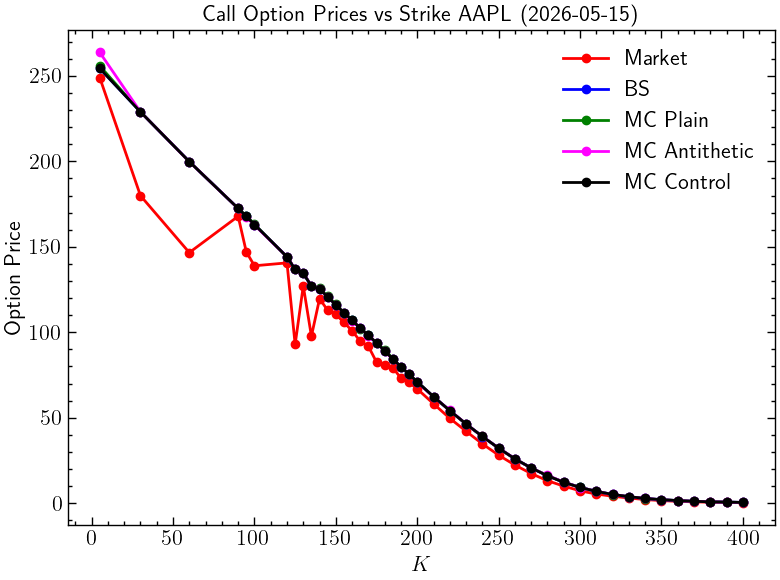

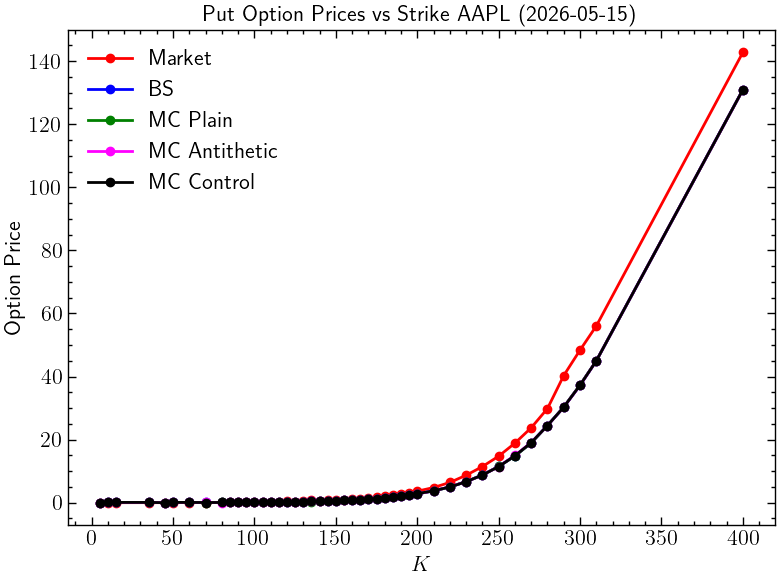

In [106]:
# Plotting the calls
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science', 'notebook', 'grid'])
plt.rcParams['text.usetex'] = True
ax = df_calls.plot(figsize=(8,6), marker='o', color = ['red', 'blue', 'green', 'magenta', 'black'])
ax.set_title(f"Call Option Prices vs Strike {ticker} ({expiry})")
ax.set_ylabel("Option Price")
ax.set_xlabel("$K$")
ax.grid(False)
ax.legend(frameon = False)
plt.tight_layout()
plt.show()

# Plotting the puts
ax = df_puts.plot(figsize=(8,6), marker='o', color = ['red', 'blue', 'green', 'magenta', 'black'])
ax.set_title(f"Put Option Prices vs Strike {ticker} ({expiry})")
ax.set_ylabel("Option Price")
ax.set_xlabel("$K$")
ax.grid(False)
ax.legend(frameon = False)
plt.tight_layout()
plt.show()


## Visualizing Error

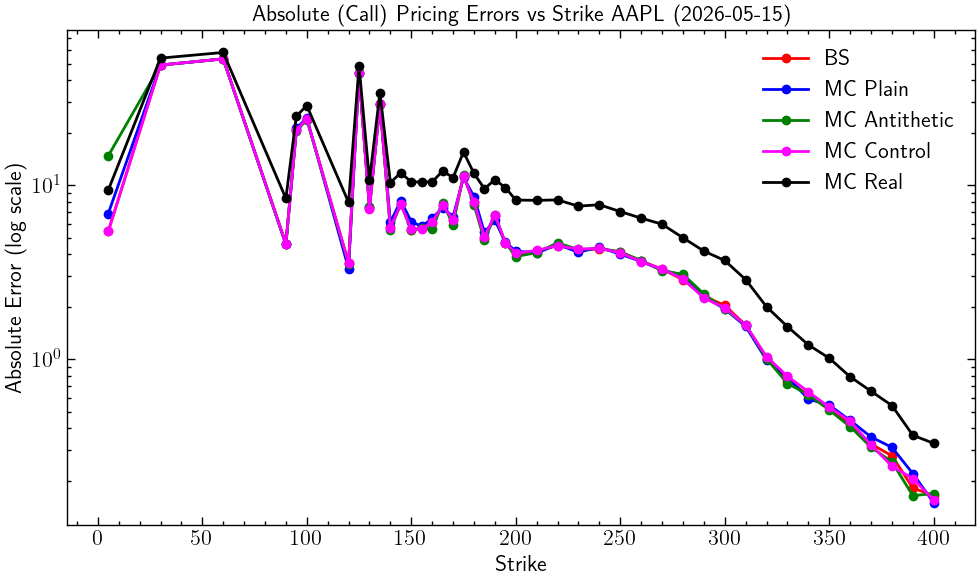

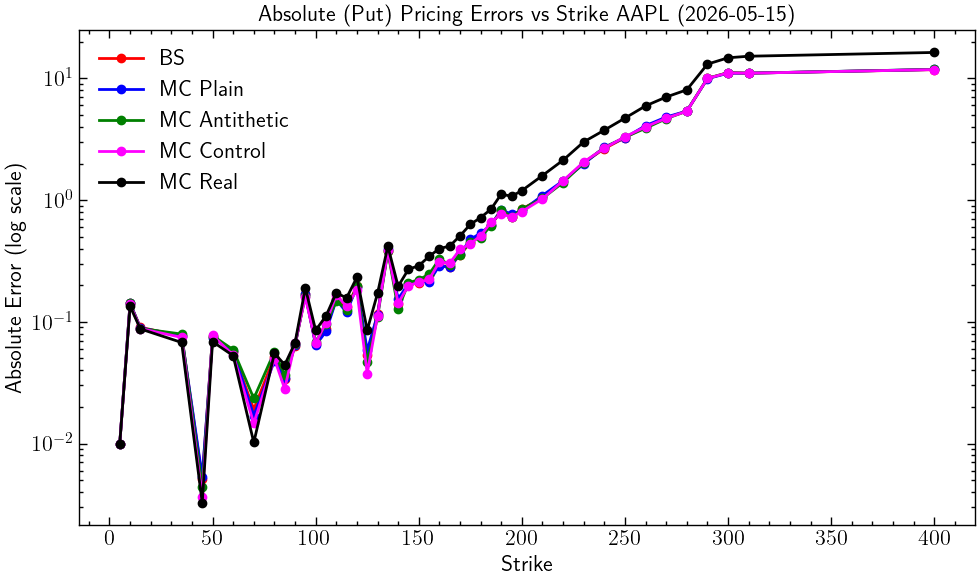

In [107]:
# Call options
call_cols = ['strike'] + calls_df.filter(like= 'abs').columns.tolist()
abs_error_df = calls_df[call_cols]
abs_error_df.columns = ['Strike', 'BS', 'MC Plain', 'MC Antithetic', 'MC Control', 'MC Real']
abs_error_df.set_index('Strike', inplace=True)

ax = abs_error_df.plot(marker='o', figsize=(10,6), color = ['red', 'blue', 'green', 'magenta', 'black'])
ax.set_yscale("log")
ax.set_title(f"Absolute (Call) Pricing Errors vs Strike {ticker} ({expiry})")
ax.set_ylabel("Absolute Error (log scale)")
ax.set_xlabel("Strike")
ax.grid(False, which="both")
ax.legend(frameon = False)
plt.tight_layout()
plt.show()


# Put options
put_cols = ['strike'] + puts_df.filter(like= 'abs').columns.tolist()
abs_error_df_ = puts_df[put_cols]
abs_error_df_.columns = ['Strike', 'BS', 'MC Plain', 'MC Antithetic', 'MC Control', 'MC Real']
abs_error_df_.set_index('Strike', inplace=True)

ax = abs_error_df_.plot(marker='o', figsize=(10,6), color = ['red', 'blue', 'green', 'magenta', 'black'])
ax.set_yscale("log")
ax.set_title(f"Absolute (Put) Pricing Errors vs Strike {ticker} ({expiry})")
ax.set_ylabel("Absolute Error (log scale)")
ax.set_xlabel("Strike")
ax.grid(False, which="both")
ax.legend(frameon = False)
plt.tight_layout()
plt.show()


# **Reflections**

When comparing Greeks and option prices across **Black–Scholes (BS)**, **Binomial (BN)**, and **Monte Carlo (MC)** methods, we observe noticeable differences.  
These differences arise from the theoretical assumptions and numerical approximations of each method.

---

### 1. Assumptions

- **Black–Scholes (BS)**
  - Continuous trading in frictionless markets (no costs, taxes, or spreads).
  - Constant volatility (`σ`) and risk-free rate (`r`).
  - Lognormal distribution of asset prices (Geometric Brownian Motion).
  - European-style exercise only.
  - Closed-form solutions for calls/puts (no discretization error).

- **Binomial (BN)**
  - Discrete-time lattice approximation of the continuous price process.
  - Price evolves through "up" and "down" states at each step.
  - Convergence to BS as number of steps `N → ∞`.
  - Can handle American options (early exercise).
  - Risk-neutral valuation applied step by step.

- **Monte Carlo (MC)**
  - Simulates a large number of random sample paths of the underlying.
  - Flexible — can model exotic payoffs, stochastic vol, jumps, path dependence.
  - Relies on the Law of Large Numbers and CLT (convergence at rate $(O(1/\sqrt{N})$)).
  - Greeks estimated via finite differences, pathwise, or likelihood ratio methods.
  - Usually priced under risk-neutral measure but can simulate real-world drift for scenario analysis.

---

### 2. Limitations

- **Black–Scholes**
  - Unrealistic assumptions: constant volatility, no jumps, no transaction costs.
  - Cannot price American-style options (except simple cases).
  - Ignores volatility smiles/skews, leading to misestimated Greeks.

- **Binomial/Trinomial**
  - Approximation errors for small number of steps.
  - Slower convergence than BS closed-form.
  - More computationally expensive for high accuracy.
  - Greeks are noisy when `N` is low.

- **Monte Carlo**
  - Computationally expensive (requires many paths for accuracy).
  - Slow convergence of variance ($(1/\sqrt{N}$)).
  - Estimating Greeks can be unstable without variance reduction.
  - Not efficient for American options without advanced techniques (e.g., Longstaff–Schwartz).

---

### 3. Model Performance Ranking (Best to Worst):
- **MC Control Variate** - Most accurate, lowest errors
- **MC Antithetic** - Good improvement over plain Monte Carlo
- **MC Plain** - Basic implementation
- **Black-Scholes** - Systematic biases, especially for deep OTM options

---

### 4. Critical Observations

- **Volatility Smile**: Market prices imply non-constant volatility
- **Computational Trade-off**: Accuracy vs computation time
- **Model Risk**: All models have limitations vs real market dynamics
- **Strike Dependency**: Error magnitude varies significantly by moneyness

---

📌 **Takeaway:**  
- **BS** is fast, elegant, but based on restrictive assumptions.  
- **BN** is flexible (American options) but introduces discretization errors.  
- **MC** is the most versatile, especially for complex payoffs, but computationally heavy and requires variance reduction.  
For practical pricing and risk management, **market-calibrated models with volatility surfaces** combined with efficient numerical methods yield the most reliable Greeks and option values.


# **References**

- Black, F., & Scholes, M. (1973). The pricing of options and corporate liabilities. *Journal of Political Economy*, 81(3), 637–654.

- Merton, R. C. (1973). Theory of rational option pricing. *Bell Journal of Economics and Management Science*, 4(1), 141–183.

- Hull, J. C. (2017). *Options, futures, and other derivatives (11th ed.)*. Pearson.

- Wilmott, P. (2006). *Paul Wilmott introduces quantitative finance (2nd ed.)*. Wiley.

- Haug, E. G. (2007). *The complete guide to option pricing formulas (2nd ed.)*. McGraw-Hill.

- Shreve, S. E. (2004). *Stochastic calculus for finance II: Continuous-time models*. Springer.




<span style="font-family:'cursive'; font-size:10px;">
&nbsp;<strong>Disclaimer:</strong> <br>  
The content and code in this notebook are intended for educational and illustrative purposes only. Option pricing involves risk, and the models presented here rely on assumptions that may not fully reflect real market conditions. Users should exercise caution, perform their own research, and consult a qualified financial professional before making any investment or trading decisions.&nbsp;
</span>